In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('Project_Data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
37227,0,1572891331,Mon Apr 20 22:55:48 PDT 2009,NO_QUERY,lady_ii,Nothing to do !
912848,4,1752415938,Sat May 09 21:51:49 PDT 2009,NO_QUERY,csoltis,@hotdogwater dayum. i dont even remember why ...
1410041,4,2056206974,Sat Jun 06 10:43:17 PDT 2009,NO_QUERY,kaelarenee7,working on metamorphosis...e-mail SicKenterpri...
805692,4,1468699634,Tue Apr 07 03:14:24 PDT 2009,NO_QUERY,Paddy,Designing a promotional pieces for an 80/90s o...
939373,4,1793660101,Thu May 14 03:32:16 PDT 2009,NO_QUERY,mr_billiam,Tweetupmellers. More to come. http://yfrog.co...


In [3]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [4]:
print('length of data is', len(df))

length of data is 1600000


In [5]:
df. shape

(1600000, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [8]:
np.sum(df.isnull().any(axis=1))

0

In [9]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


In [10]:
df['target'].unique()

array([0, 4], dtype=int64)

In [11]:
df['target'].nunique()

2

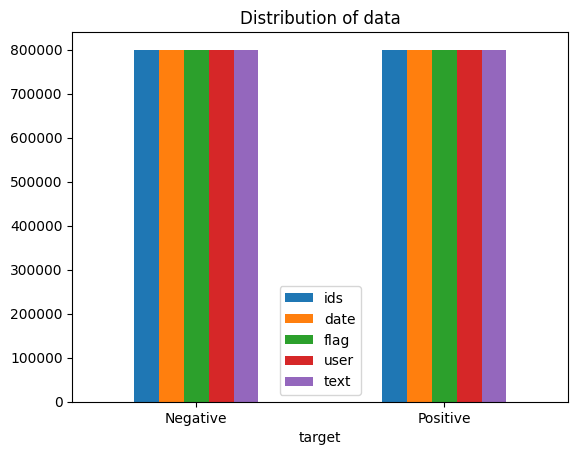

In [43]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data')
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])


<Axes: xlabel='target', ylabel='count'>

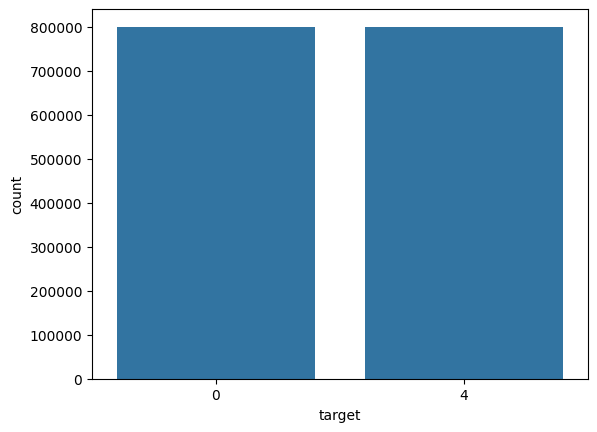

In [13]:
import seaborn as sns
sns.countplot(x='target', data=df)

In [14]:
data=df[['text','target']]

In [15]:
data['target'] = data['target'].replace(4,1)

C:\Users\sangh\AppData\Local\Temp\ipykernel_20620\2499609609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [16]:
data['target'].unique()

array([0, 1], dtype=int64)

In [17]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [18]:
data_pos = data_pos.iloc[:int(100000)]
data_neg = data_neg.iloc[:int(100000)]

In [19]:
dataset = pd.concat([data_pos, data_neg])

In [20]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

99995    my son has developed the new habit of waking u...
99996    looks like my routers broke  more tweets from ...
99997    i really dont want to be in college right now....
99998                          @flossa  *offers you pepto*
99999    @josiehobo i would sooooo be there if i didn't...
Name: text, dtype: object

In [21]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [22]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [23]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

99995    son developed new habit waking 530am im second...
99996                 looks like routers broke tweets fone
99997       really dont want college right now wish sunny 
99998                                  flossa offers pepto
99999                josiehobo would sooooo didnt revision
Name: text, dtype: object

In [24]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

99995    son developed new habit waking 530am im second...
99996                 looks like routers broke tweets fone
99997       really dont want college right now wish sunny 
99998                                  flossa offers pepto
99999                josiehobo would sooooo didnt revision
Name: text, dtype: object

In [25]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

99995    son developed new habit waking 530am im second...
99996                 looks like routers broke tweets fone
99997       really dont want college right now wish sunny 
99998                                  flossa offers pepto
99999                josiehobo would sooooo didnt revision
Name: text, dtype: object

In [26]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

99995    son developed new habit waking am im second po...
99996                 looks like routers broke tweets fone
99997       really dont want college right now wish sunny 
99998                                  flossa offers pepto
99999                josiehobo would sooooo didnt revision
Name: text, dtype: object

In [27]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [28]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [32]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [31]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sangh\AppData\Roaming\nltk_data...


True

In [33]:
X=data.text
y=data.target

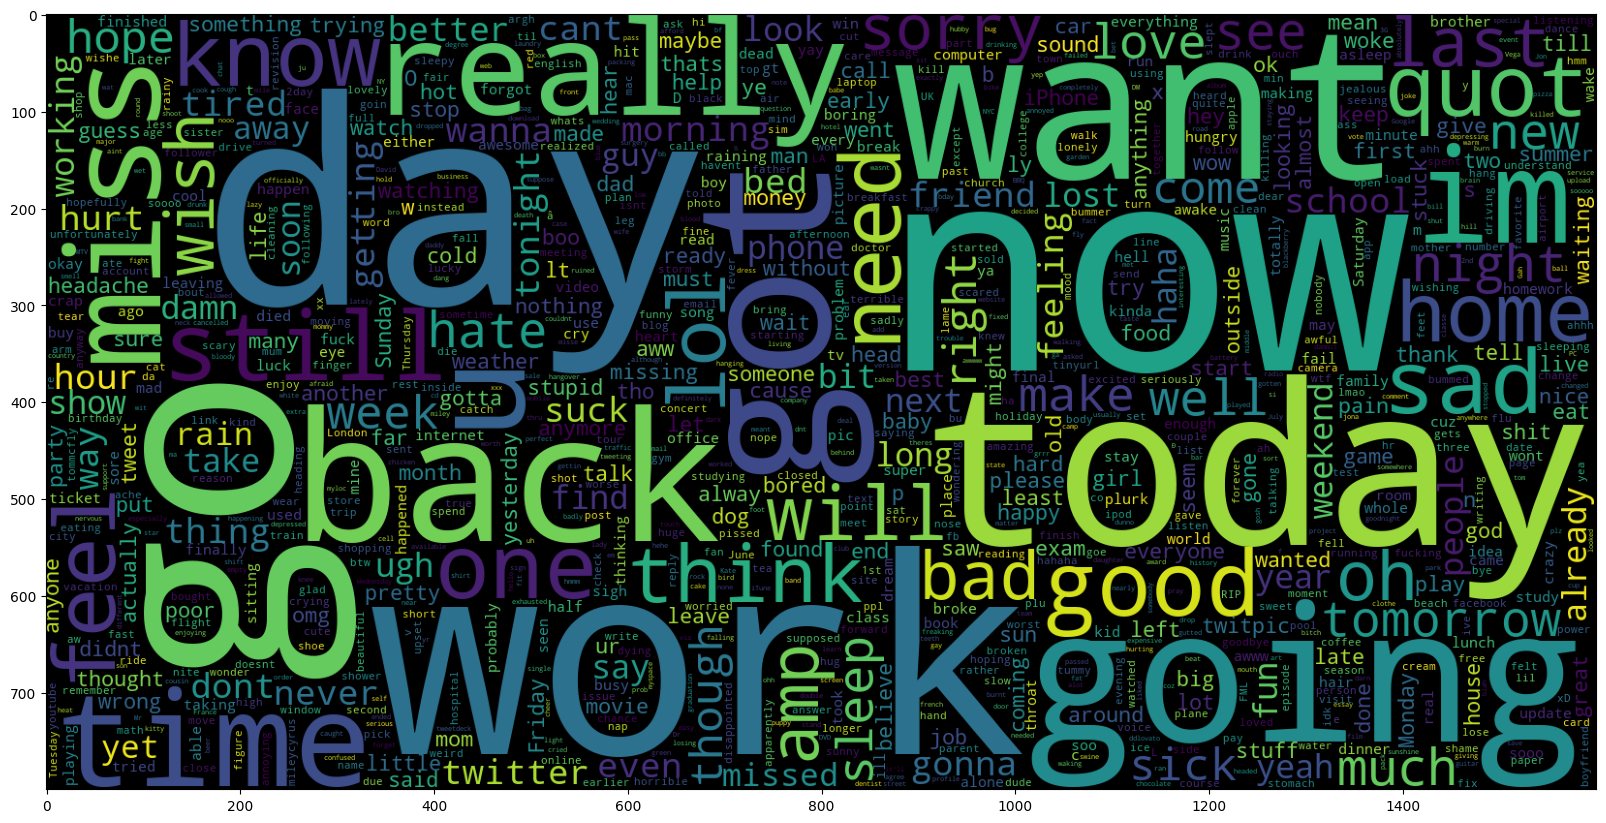

In [34]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

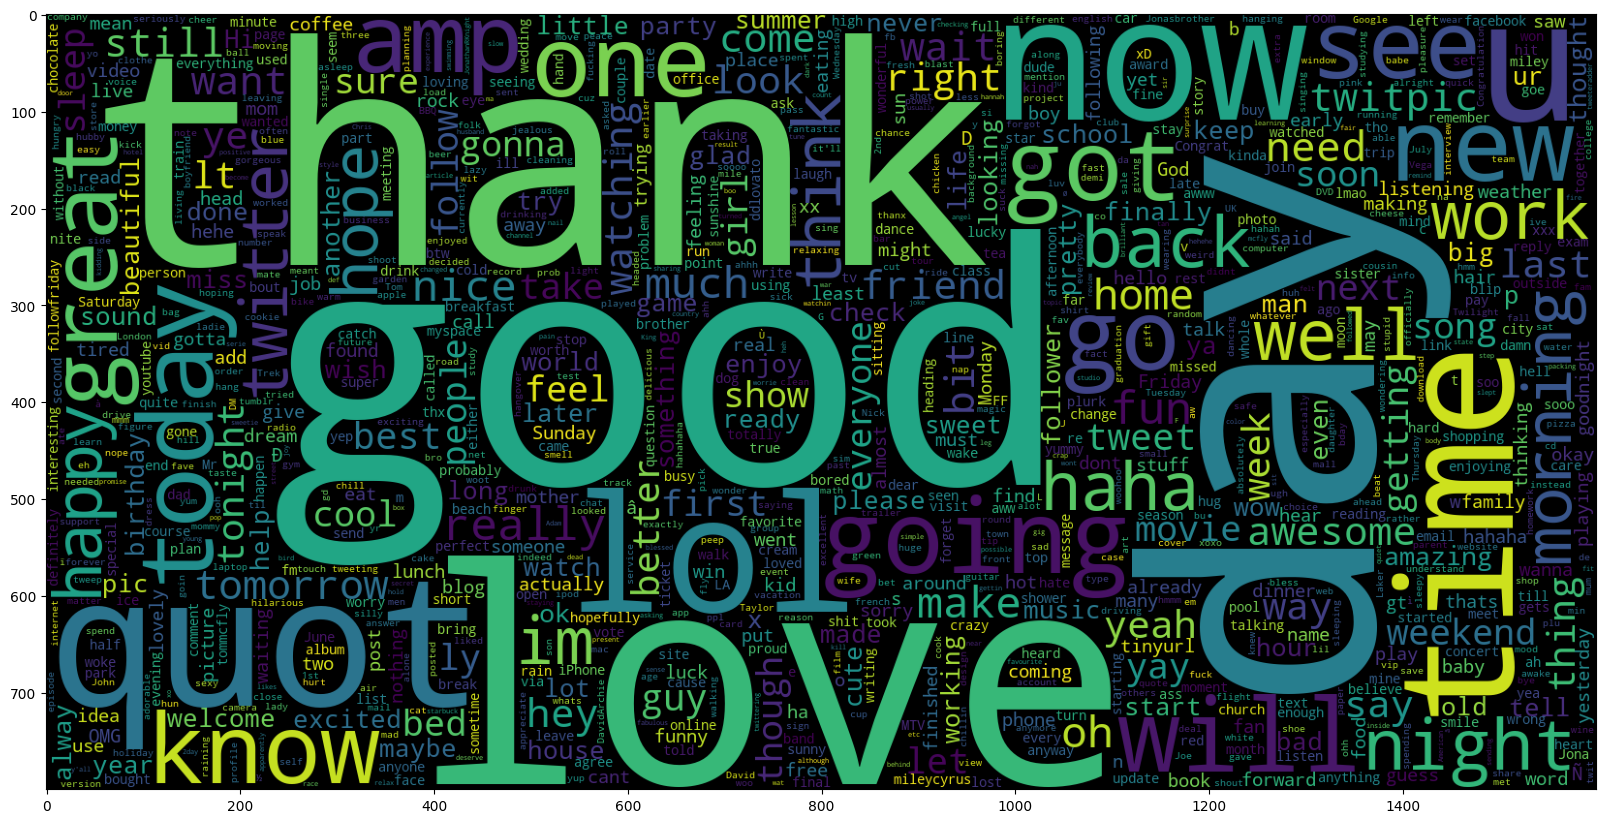

In [35]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [36]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state =42)

In [38]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [39]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [40]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.83      0.82      0.82    159494
           1       0.82      0.83      0.83    160506

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



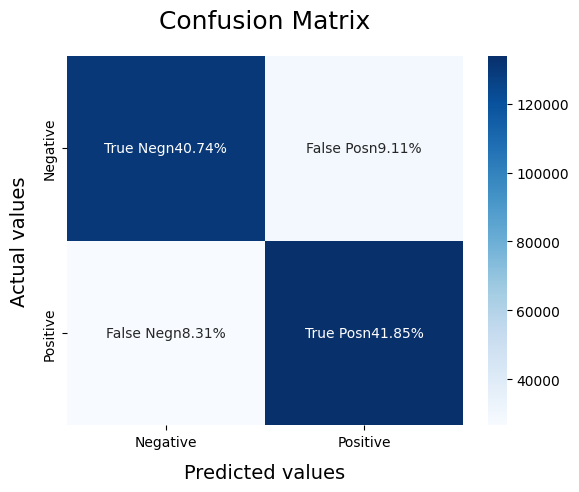

In [41]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

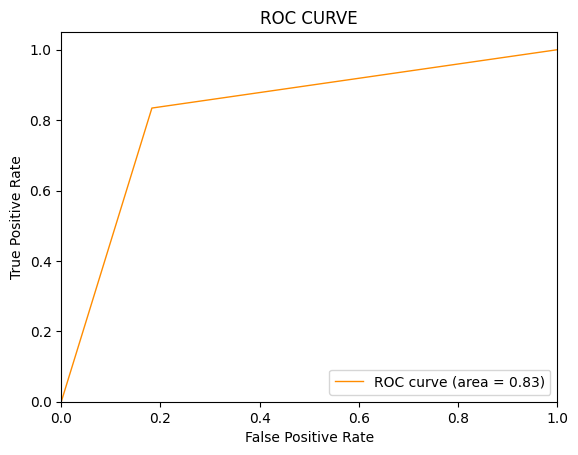

In [42]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()